In [1]:
# Задача
# 1. Сгенерируйте набор данных для предсказания временных последовательностей. Выполните тренировку RNN
# 2. Модифицируйте сеть, используя в качестве рекуррентного слоя LSTM слой библиотеки pytorch.
# https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

# 3. решите задачу набора данных лекции 7.

In [85]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

num_sequences = 1000
seq_length = 100

x = np.linspace(0, 10, seq_length)
y = np.cos(x) + np.random.normal(0, 0.5, size=(num_sequences, seq_length))

data_tensor = torch.tensor(y, dtype=torch.float32)

In [86]:
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out
    
input_data = data_tensor[:, :-1].unsqueeze(-1)
target_data = data_tensor[:, -1].unsqueeze(-1)

train_size = int(0.75 * len(y))
train_data, test_data = input_data[:train_size], input_data[train_size:]
train_target, test_target = target_data[:train_size], target_data[train_size:]

model_rnn = RNNModel(input_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    model_rnn.train()
    optimizer.zero_grad()
    
    output = model_rnn(train_data)
    loss = criterion(output, train_target)
    
    loss.backward()
    optimizer.step()
    

model_rnn.eval()
predictions = model_rnn(test_data)
test_loss = criterion(predictions, test_target)
print(f"Test Loss: {test_loss.item()}")


Test Loss: 0.26564860343933105


In [87]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.fc(out[:, -1, :])  
        return out

model_lstm = LSTMModel(input_size=1)
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

for epoch in range(epochs):
    model_lstm.train()
    optimizer.zero_grad()
    
    output = model_lstm(train_data)
    loss = criterion(output, train_target)
    
    loss.backward()
    optimizer.step()

model_lstm.eval()
predictions = model_lstm(test_data)
test_loss = criterion(predictions, test_target)
print(f"Test Loss: {test_loss.item()}")


Test Loss: 0.2676417827606201


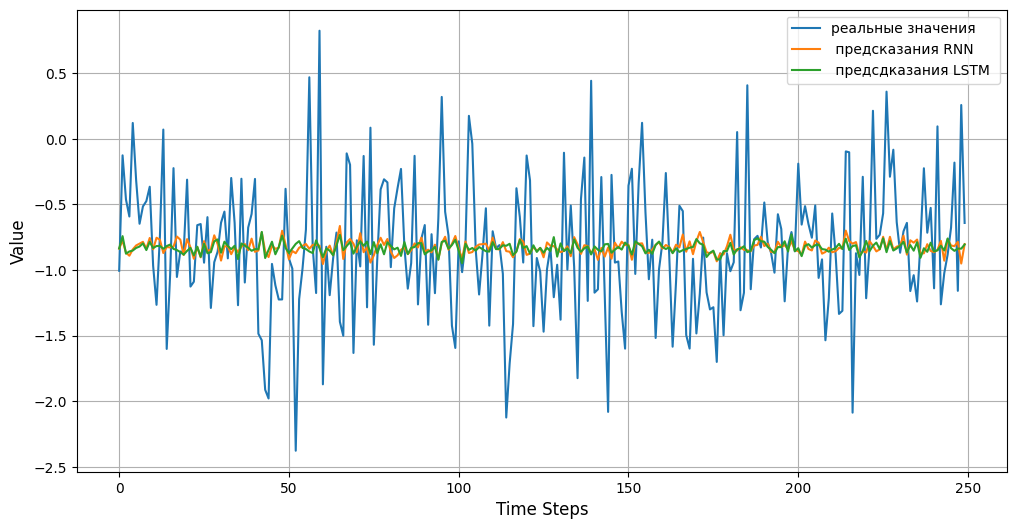

In [94]:
import matplotlib.pyplot as plt

model_rnn.eval()
rnn_predictions = model_rnn(test_data)

model_lstm.eval()
lstm_predictions = model_lstm(test_data)

rnn_predictions = rnn_predictions.tolist()
lstm_predictions = lstm_predictions.tolist()

plt.figure(figsize=(12, 6))
plt.plot(test_target, label='реальные значения',  )
plt.plot(rnn_predictions, label=' предсказания RNN ', )
plt.plot(lstm_predictions, label=' предсдказания LSTM ')


plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# 3. решите задачу набора данных лекции 7.

In [19]:
# Задание (файл 2)
# Разделить данные на N групп. (возможно, выбрать первые M данных для обучения)
# Реализовать предсказание ARIMA для 2 (тренировочной группы) на основе 1. Рассчитать MSE.
# Исследовать качество работы модели в зависимости от параметров (для групп 1-2).
# (1)Выполнить итеративное предсказание, данные для каждого следующего предсказания обновлять по методу
# "экспоненциальное среднее".

MSE ARIMA: 0.29511166589252696


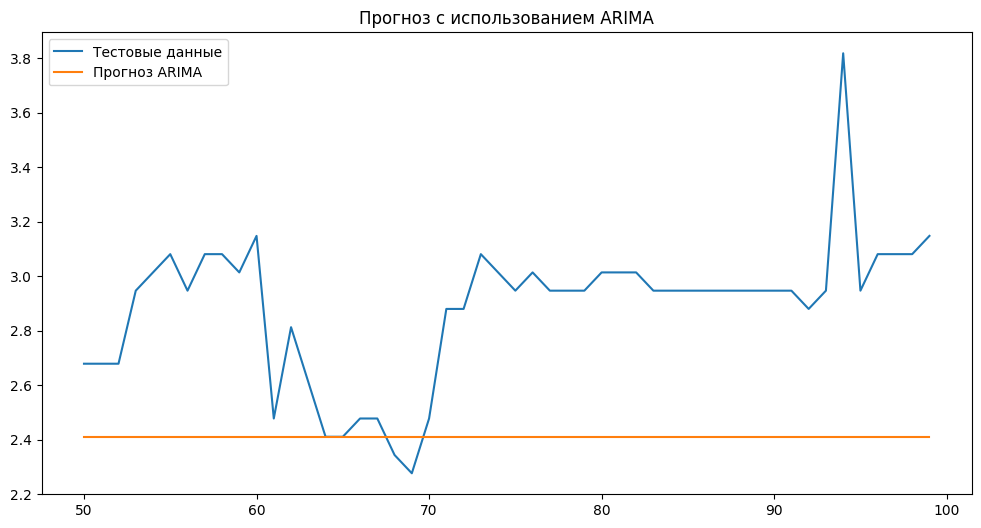

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

df = pd.read_csv('ETTm1.csv')
x = df.HULL

M = 50
N = 50  

x_train = x[:M]  
x_test = x[M:M+N] 

model_arima = ARIMA(x_train).fit()
predictions_arima = model_arima.forecast(len(x_test))

mse = mean_squared_error(x_test, predictions_arima)
print(f'MSE ARIMA: {mse}')

plt.figure(figsize=(12, 6))
plt.plot(x_test, label='Тестовые данные')
plt.plot(predictions_arima, label='Прогноз ARIMA')
plt.title('Прогноз с использованием ARIMA')
plt.legend()
plt.show()

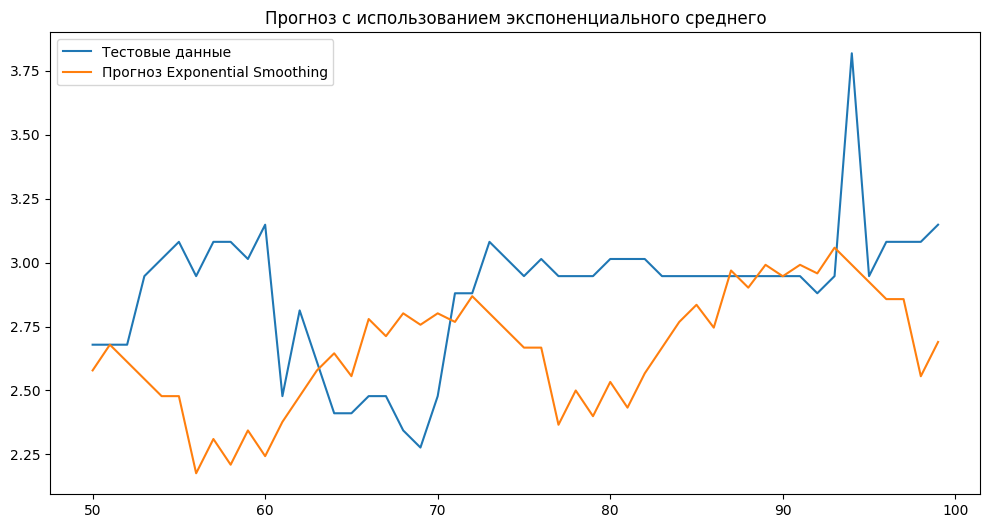

MSE: 0.16722805414503003


In [97]:
x_train_iter = x[:M]
x_test_iter = x[M:M+N]

exp_model = ExponentialSmoothing(x_train_iter, trend='add', seasonal='add', seasonal_periods=21).fit()
exp_predictions = exp_model.forecast(len(x_test_iter))

plt.figure(figsize=(12, 6))
plt.plot(x_test_iter, label='Тестовые данные')
plt.plot(exp_predictions, label='Прогноз Exponential Smoothing')
plt.title('Прогноз с использованием экспоненциального среднего')
plt.legend()
plt.show()

mse_exp = mean_squared_error(x_test_iter, exp_predictions)
print(f'MSE: {mse_exp}')